In [1]:
from __future__ import division
import hoomd
import hoomd.md

In [2]:
hoomd.context.initialize("");

HOOMD-blue 2.3.0 DOUBLE HPMC_MIXED SSE SSE2 SSE3 
Compiled: 04/25/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


In [3]:
#This will create a simple lattice of the center of mass particles.
#These particles define the mass and moment of inertia of the rigid body. 
#Will create the center of mass particles of type R.

uc = hoomd.lattice.unitcell(N = 1,
                           a1 = [10.8, 0, 0],
                           a2 = [0, 1.2, 0],
                           a3 = [0, 0, 1.2],
                           dimensions = 3,
                           position = [[0,0,0]],
                           type_name = ['R'],
                           mass = [1.0],
                           #This is a length 3 vector 
                           moment_inertia = [[0,
                                             1/12*1.0*8**2,
                                             1/12*1.0*8**2]],
                           orientation = [[1,0,0,0]]);
system = hoomd.init.create_lattice(unitcell=uc, n = [2,18,18]);

notice(2): Group "all" created containing 648 particles


In [4]:
#Adds the particle type for hte constituent particles. Constituents 
#can not share a type with any rigid central particle.

system.particles.types.add('A');

In [5]:
#Define each rigid body type.
rigid = hoomd.md.constrain.rigid();
rigid.set_param('R',
               #I think this is making the ideal line segment length equal to 8. 
               types=['A']*8,
               positions=[(-4,0,0),(-3,0,0),(-2,0,0),(-1,0,0),(1,0,0),
                         (2,0,0),(3,0,0),(4,0,0)]);


"The positions of the partciles in the local reference frame must be such that the moment of inertia tensor is diagonal. The actual values specified need not assume anything about the body, such as point particles."

"This example is creating rodes that are 9 particles long."

In [6]:
#Instructs the rigid constraint to create the constituent particles
rigid.create_bodies()
#Now the rods are complete!

notice(2): constrain.rigid(): Creating 648 rigid bodies (adding 5184 particles)


Have no way to run the ex_render script so will have to make a gsd file (I think) so that I can see the things in VMD on my laptop. 

In [7]:
#"The WCA potential hsa the same functional form as Lennard-Jones,
#but r_cut = 2^(1/6)*sigma and is shifted up to 0 at the cutoff."

#Specifies the neighborlist acceleration structureto find neighboring
#particles efficiently by using the cell method. 

n1 = hoomd.md.nlist.cell()

In [8]:
#Defining the functional form of the pair interaction and evaluating using
#the given neighbor list acceleration structure.

lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=n1)
lj.set_params(mode='shift')

** = ^ = exponent

In [9]:
#Specifying pair potential parameters for every pair type.
#R and A exist in the system for the rigid bodies but both should interact identically.
#The R particle is in the center of the rod.

lj.pair_coeff.set(['R', 'A'], ['R', 'A'], epsilon=1.0, sigma=1.0)

NOW GOING TO SELECT AN INTEGRATOR

In [10]:
hoomd.md.integrate.mode_standard(dt=0.005);

In [11]:
rigid = hoomd.group.rigid_center();
hoomd.md.integrate.langevin(group=rigid, kT=1.0, seed=42);

notice(2): Group "rigid_center" created containing 648 particles
notice(2): integrate.langevin/bd is using specified gamma values


In [12]:
hoomd.analyze.log(filename="log-output3.log",
                 quantities=['potential_energy',
                            'translational_kinetic_energy',
                            'rotational_kinetic_energy'],
                 period=100,
                 overwrite=True);

In [13]:
hoomd.dump.gsd("trajectory3.gsd",
              period=2e3,
              group=hoomd.group.all(),
              overwrite=True);

In [14]:
hoomd.run(1e4)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 5832
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:10 | Step 3901 / 10000 | TPS 390.014 | ETA 00:00:15
Time 00:00:20 | Step 7635 / 10000 | TPS 373.28 | ETA 00:00:06
Time 00:00:27 | Step 10000 / 10000 | TPS 337.644 | ETA 00:00:00
Average TPS: 370.211
---------
-- Neighborlist stats:
1671 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 11 / n_neigh_avg: 3.1214
shortest rebuild period: 4
-- Cell list stats:
Dimension: 14, 14, 14
n_min    : 0 / n_max: 6 / n_avg: 2.12536
** run complete **


In [15]:
import numpy
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='log-output3.log', skip_header=True)

Text(0,0.5,'potential_energy')

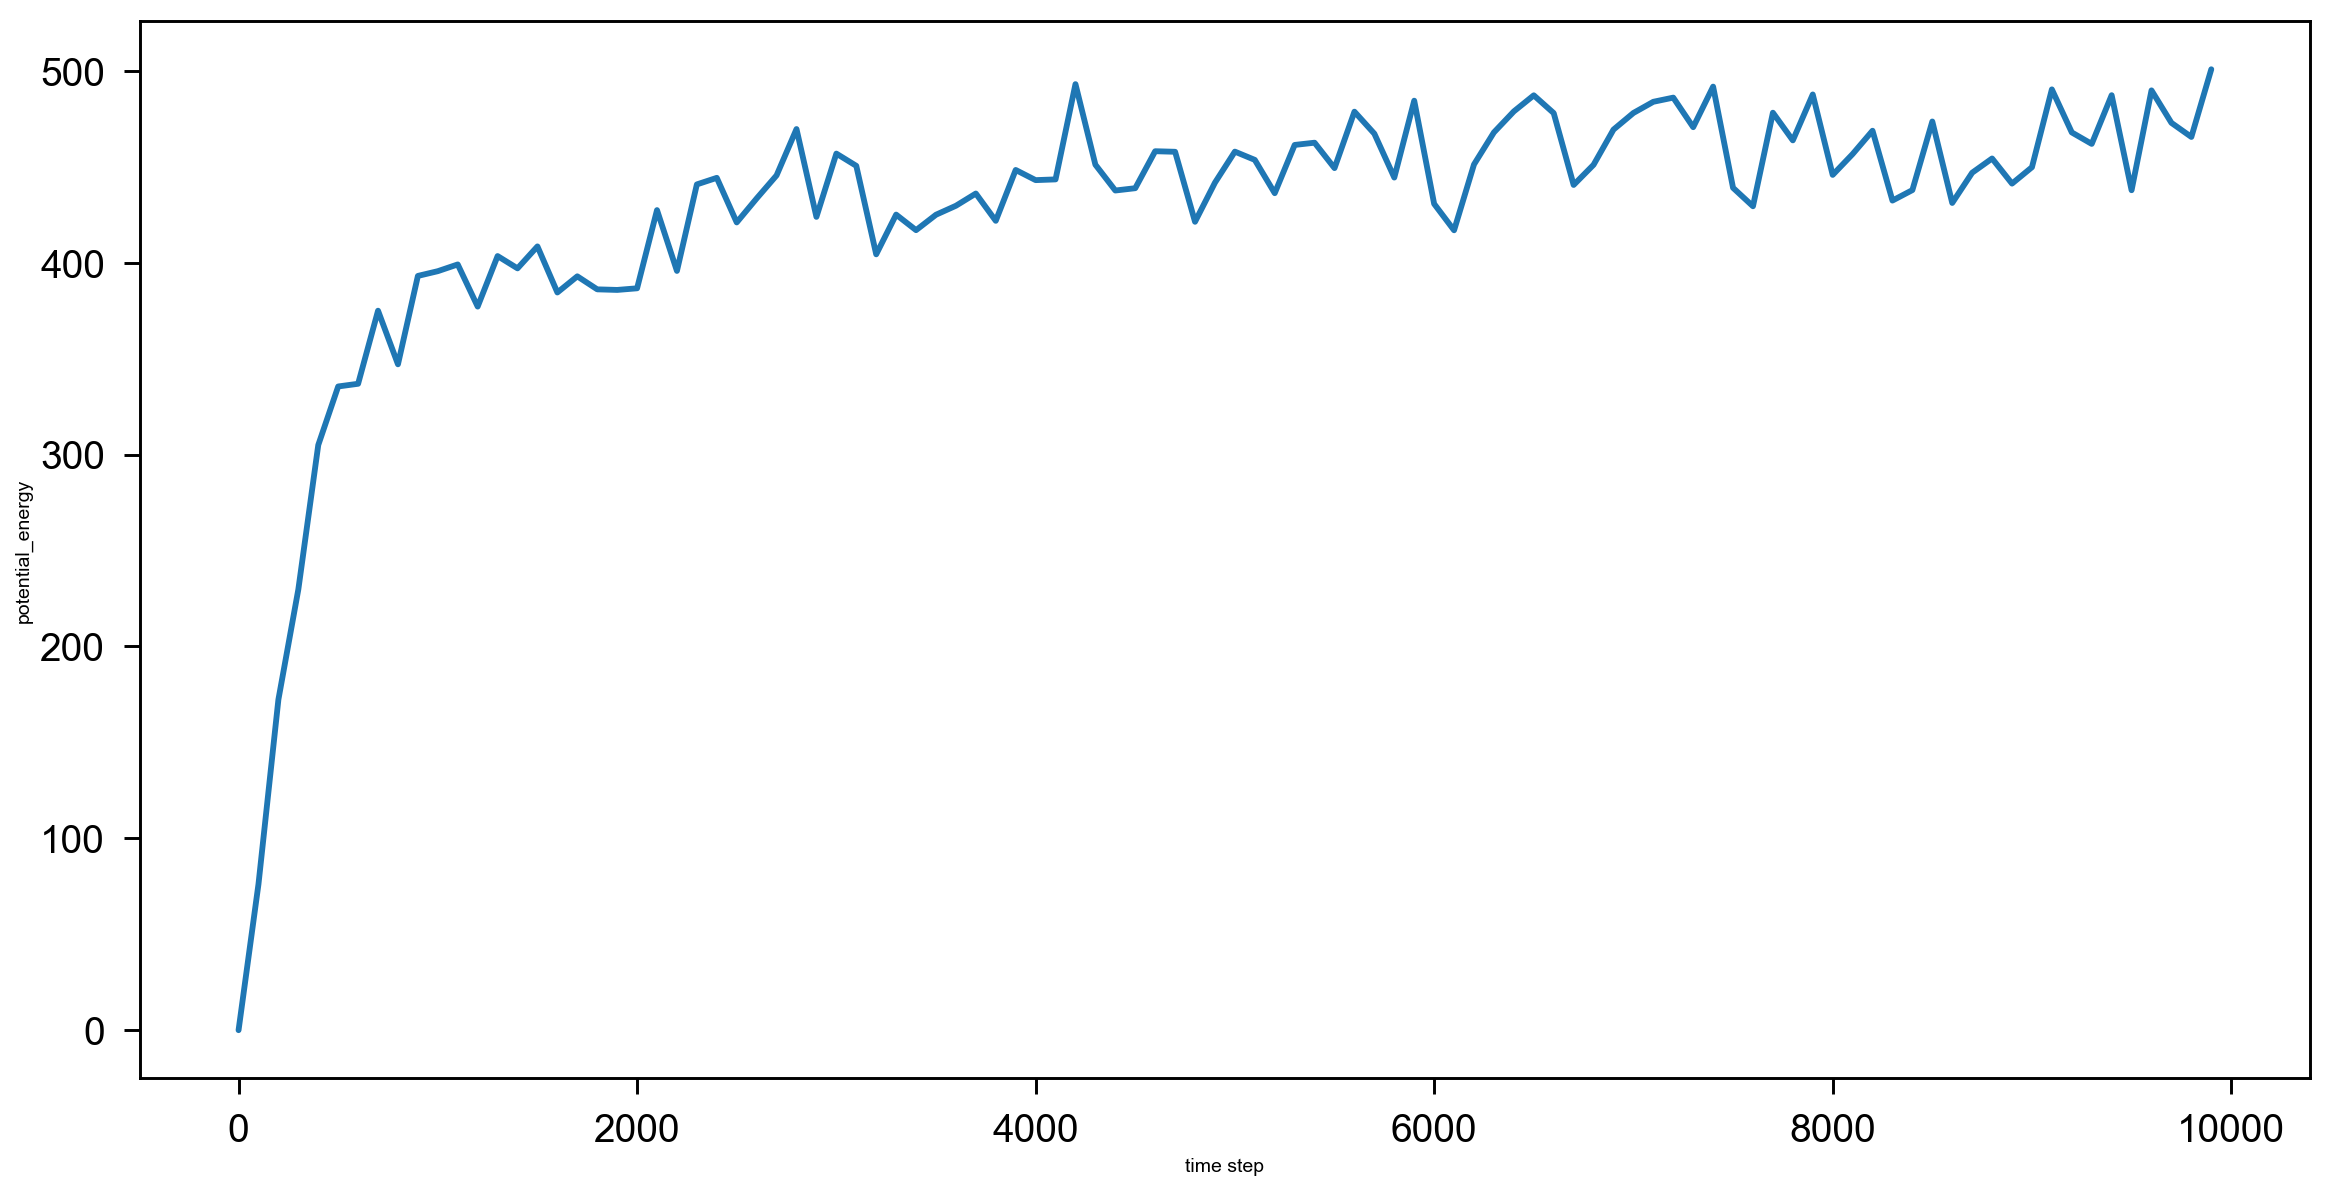

In [19]:
pyplot.figure(figsize=(20,10), dpi=140)
pyplot.plot(data[:,0], data[:,1])
pyplot.xlabel('time step')
pyplot.ylabel('potential_energy')

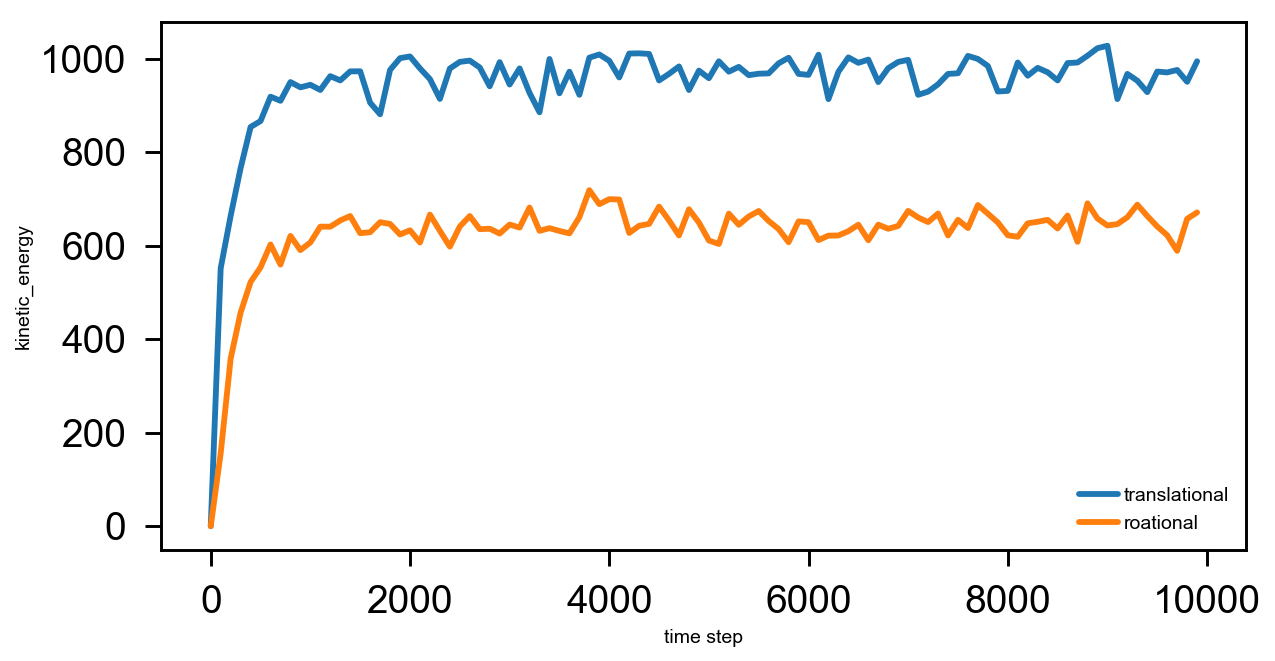

In [20]:
pyplot.figure(figsize=(10,5), dpi=140)
pyplot.plot(data[:,0], data[:,2])
pyplot.plot(data[:,0], data[:,3])
pyplot.xlabel('time step')
pyplot.ylabel('kinetic_energy')
pyplot.legend(['translational', 'roational'], loc='lower right')